Import libraries

In [1]:
from utils import AdamOptimizer, VariationalInference, BlackBoxVariationalInference
import autograd.numpy as np
import torch 
from torchvision.datasets import MNIST
from models.LeNet5 import LeNet


Get data

In [2]:
# load the MNIST dataset
mnist_train = MNIST('./datasets', train=True, download=True)
mnist_test = MNIST('./datasets', train=False, download=True)

# load the data
xtrain = mnist_train.data
ytrain = mnist_train.targets
xtest = mnist_test.data
ytest = mnist_test.targets

# normalize the data
xtrain = xtrain.float()/255
xtest = xtest.float()/255

#insert a channel dimension
xtrain = xtrain.unsqueeze(1)
xtest = xtest.unsqueeze(1)

#print shapes
print(xtrain.shape)

torch.Size([60000, 1, 28, 28])


Load pre-trained model

In [3]:
# the softmax function should be modified to handle overflow / division by zero
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=1)[:, None]

net = LeNet()
weights = torch.load('checkpoints\LeNet5_acc_95.12%.pth') # pre-trained weights
net.load_state_dict(weights)

# check that I can make predictions
y = softmax(net(xtest).detach().numpy())


test_acc = 100 * (ytest.numpy()==np.argmax(y, axis = 1)).mean()
print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 95.12%


Create a random subspace (P)

In [4]:
# get the number of parameters in the model
theta_map = torch.cat([w.flatten() for w in weights.values()]) # flatten the weights
theta_map = theta_map.detach().numpy() #don't track gradients and convert to numpy

# number of parameters in the model
D = theta_map.shape[0] 

# choose size of subspace (k)
K = 5

P = torch.randn(D, K)
P = P / P.sum(dim = 0) # columns sum to 1
P.shape
P = P.numpy()

Do SWA as proposed in the article

In [5]:
#swa_model = torch.optim.swa_utils.AveragedModel(net)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# not done yet, see https://pytorch.org/docs/stable/optim.html#module-torch.optim.swa_utils


Apply BBVI to get the posterior to approximate $p(z|D)$

The prior on $z$ is $N(0, \sigma_k^2\cdot I_k)$

The likelihood is $p(D|z) = p_M(D|\theta = \theta_0 + Pz)$ where 
$$
p_M(\cdot) = P(y|NN) = \prod_{n=1}^N Cat(y_n|\pi (NN(x_n)))
$$
and $NN$ is a neural network with weights $\theta = \theta_0+Pz$ for some fixed $\theta_0$ and $P$. We will choose $\theta_0$ to be the MAP solution or stochastic weight average (SWA) as proposed in "Subspace Inference for Bayesian Deep Learning".

In [6]:
log_npdf = lambda x, m, v: -(x-m)**2/(2*v) - 0.5*np.log(2*np.pi*v)

import autograd.numpy as anp


def log_prior_pdf(z, prior_mean, prior_var):
    log_prior = np.sum(log_npdf(z, prior_mean, prior_var), axis=1)
    return log_prior


def new_weights_in_NN(model, new_weight_vector):
    '''
    Function that takes the network and updates the weights
    '''
    with torch.no_grad():  # Disable gradient tracking for manual weight assignment
        current_index = 0
        for param in model.parameters():
            # Get the number of elements in the parameter tensor
            num_params = param.numel()
            # Assign new weights by reshaping the corresponding slice from the weight vector
            param.copy_(new_weight_vector[current_index:current_index + num_params].view_as(param))
            # Update the index to move to the next set of weights in the vector
            current_index += num_params
    return model



def log_like_NN_classification(X, y, theta_s):
    """
    Implements the log likelihood function for the classification NN with categorical likelihood.
    S is number of MC samples, N is number of datapoints in likelihood and D is the dimensionality of the model (number of weights).

    Inputs:
    X              -- Data (np.array of size N x D)
    y              -- vector of target (np.array of size N)
    theta_s        -- vector of weights (np.array of size (S, D))

    outputs: 
    log_likelihood -- Array of log likelihood for each sample in z (np.array of size S)
     """       
    # to handle the case when theta_s is not Numpy but of type ArrayBox
    # this happens in the bbvi.fit call
    if isinstance(theta_s, anp.numpy_boxes.ArrayBox):
        theta_s = theta_s._value   

    S = theta_s.shape[0]
    net = LeNet()
    log_likelihood = 0
    
    for i in range(S):
        net_s = new_weights_in_NN(net, torch.tensor(theta_s[i]).float())
        outputs = softmax(net_s(X).detach().numpy())
        
        
        
        #categorical log likelihood
        log_likelihood += np.sum(np.log(outputs[np.arange(len(y)), y]))
    
    return log_likelihood / S




From the Bayesian Machine Learning course we have a code implementation of the BBVI 

In [7]:

max_itt = 2000
step_size = 0.25
num_samples = 25
batch_size = 100
seed = 0
verbose = True

bbvi = BlackBoxVariationalInference(theta_map, P, 
                                    log_prior_pdf, log_like_NN_classification, 
                                    K, step_size, max_itt, num_samples, batch_size, 
                                    seed, verbose, T = 1000) # in the paper they use T = 5000 for image classification
bbvi.fit(xtrain, ytrain)


Fitting approximation using Black-box VI
	Itt:   249, ELBO = -28.53
	Itt:   499, ELBO = -28.70
	Itt:   749, ELBO = -29.38
	Itt:   999, ELBO = -28.92
	Itt:  1249, ELBO = -29.64
	Itt:  1499, ELBO = -30.08
	Itt:  1749, ELBO = -29.28
	Itt:  1999, ELBO = -29.09
	Optimization done in 574.40s



Make some plots

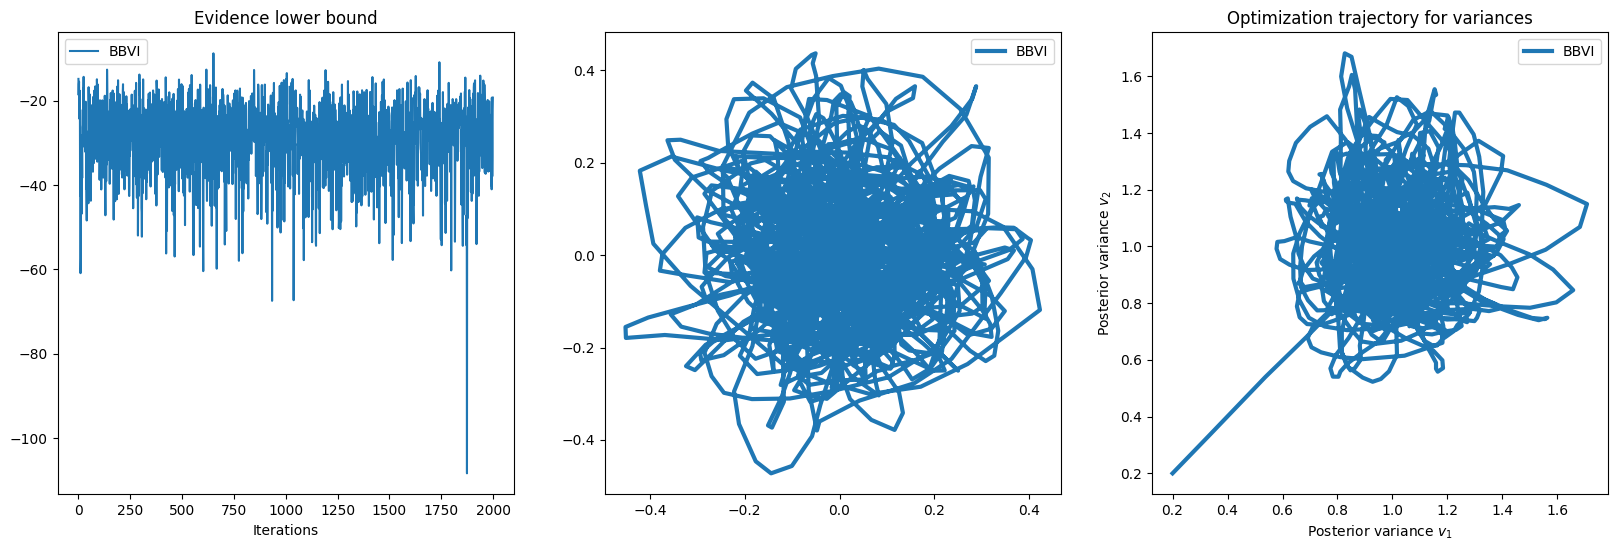

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].plot(bbvi.ELBO_history, label='BBVI')
axes[0].set(title='Evidence lower bound', xlabel='Iterations')
axes[0].legend()

axes[1].plot(bbvi.m_history[:, 0], bbvi.m_history[:, 1], '-', label='BBVI', linewidth=3)

axes[2].plot(bbvi.v_history[:, 0], bbvi.v_history[:, 1], '-',  label='BBVI', linewidth=3)
axes[2].set(xlabel='Posterior variance $v_1$', ylabel='Posterior variance $v_2$', title='Optimization trajectory for variances')

for i in range(3):
    axes.flat[i].legend()

Not much seems to happen... maybe because of our choice of variational family?

Bayesian model averaging on new test data

In [15]:
import torch
import numpy as np

def posterior_predictive(bbvi, num_samples, Xtest, network):

    num_images = Xtest.shape[0]  

    z_samples = bbvi.generate_posterior_samples(num_samples)  
    weight_samples = theta_map + z_samples @ P.T  
    
    stacked_predictions = np.zeros((num_images, num_samples, 10)) # 10 classes

    for i in range(num_images):
        Xtest_one_image = Xtest[i].unsqueeze(0)  # extract one test image (1 x input_size)

        # Loop through the sampled weights and compute predictions for each sample
        for j, weight in enumerate(weight_samples):
            net1 = new_weights_in_NN(network, torch.tensor(weight))
            
            pred = torch.softmax(net1(Xtest_one_image), dim=1).detach().numpy()  # shape: (1, num_classes)
            
            # Store the prediction for this image and this sample
            stacked_predictions[i, j, :] = pred  # remove the extra batch dimension
    
    # Return the stacked predictions
    return stacked_predictions


In [16]:
posterior_predictions = posterior_predictive(bbvi, num_samples=100 , Xtest= xtest[0:10,:,:,:], network = LeNet())

In [17]:
posterior_predictions.shape

(10, 100, 10)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_posterior_predictive(stacked_predictions, image_idx, xtest):
 
    
    preds_for_image = stacked_predictions[image_idx]  # shape: (num_samples, num_classes)
    # Create a figure with 2 subplots: one for the image and one for the density plot
    fig, (ax_img, ax_density) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot the image
    ax_img.imshow(xtest[image_idx,:,:,:].squeeze(0), cmap='gray')
    ax_img.set_title(f'Image {image_idx + 1}')
    ax_img.axis('off')  # Hide axes for the image subplot
    
    # Plot the density plots
    ax_density.set_title(f'Density Plot of Class Probabilities for Image {image_idx + 1}')
    colors = sns.color_palette("tab10", 10)  # A palette with 10 distinct colors

    # Plot densities for each class
    for class_idx in range(10):
        class_preds = preds_for_image[:, class_idx]
       
        sns.kdeplot(class_preds, ax=ax_density, fill=True, color=colors[class_idx],
                        label=f'Class {class_idx}', linewidth=2)
        
    
    # Set axis limits and labels
    ax_density.set_xlim(0, 1)  
    ax_density.set_yscale('log')
    ax_density.set_ylim(1,1000)
    ax_density.set_xlabel('Probability')
    ax_density.set_ylabel('Density')

    # Add a legend to the plot, positioned on the right
    ax_density.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust plot aesthetics
    sns.despine(ax=ax_density)  # Remove the top and right spines for a cleaner look
    ax_density.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add a grid with dashed lines
    
    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right side for the legend
    
    # Show the plot
    plt.show()



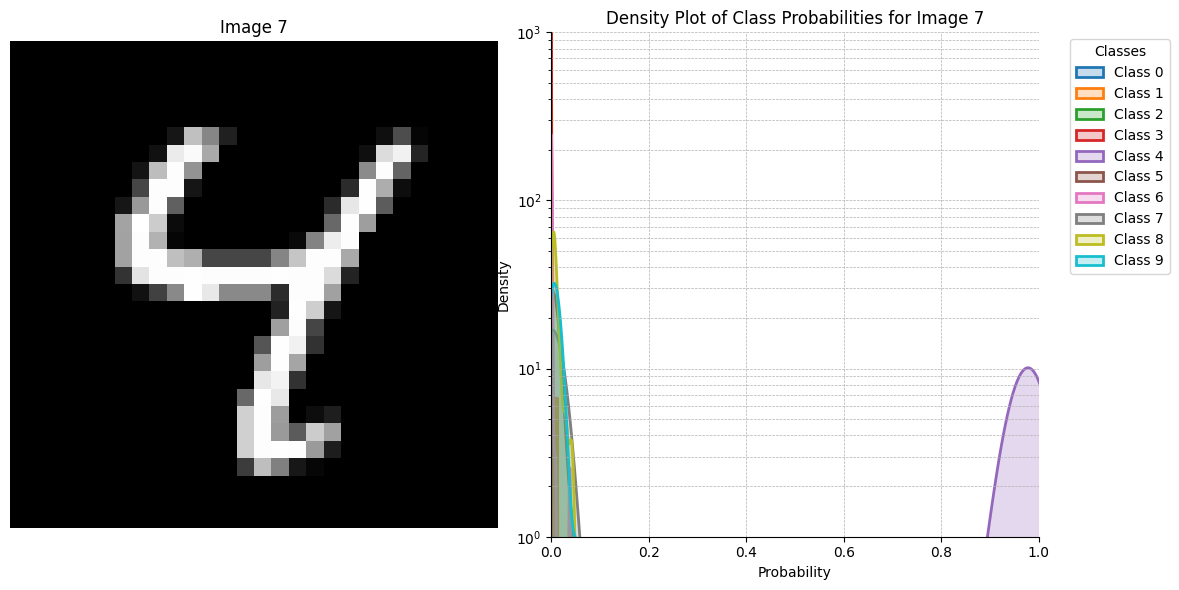

In [19]:
plot_posterior_predictive(posterior_predictions, image_idx=6, xtest=xtest)  
